# GHG HLM on Scope 3 source Use of Sold Products

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import warnings
from statsmodels.regression.mixed_linear_model import MixedLM


#read in dataset from GHG_post_outliers data set
use_sold_products=pd.read_csv('/Users/amberjensen/Desktop/GHG_Emissions_Project/use_sold_products.csv')

In [2]:
#check for info
use_sold_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_name                2253 non-null   object 
 1   account_id                  2253 non-null   int64  
 2   Year                        2253 non-null   int64  
 3   incorporated_country        2253 non-null   object 
 4   Primary activity            2253 non-null   object 
 5   Primary sector              2253 non-null   object 
 6   Market_Cap_USD              2013 non-null   float64
 7   Third_party_verification    2252 non-null   object 
 8   Revenue_USD                 2008 non-null   float64
 9   ebitda_USD                  2008 non-null   float64
 10  grossProfit_USD             2008 non-null   float64
 11  netIncome_USD               2008 non-null   float64
 12  cashAndCashEquivalents_USD  2008 non-null   float64
 13  shortTermInvestments_USD    2008 

In [3]:
#show a df for use_sold_products
use_sold_products.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,Aptiv,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,No third-party verification or assurance,1.443500e+10,2.260000e+09,...,99000000.0,1.248000e+10,8.810000e+09,171000000.0,4.344000e+09,3.670000e+09,Use of sold products,3556030.00,380471.810000,4072324
1,AstraZeneca,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,Third-party verification or assurance process ...,2.209000e+10,7.165000e+09,...,113000000.0,6.065100e+10,4.660700e+10,922000000.0,1.911300e+10,1.404400e+10,Use of sold products,778885.00,707252.916667,4072324
2,Barratt Developments plc,23046,2018,United Kingdom,Residential building construction,Construction,6.017675e+09,Third-party verification or assurance process ...,6.049137e+09,1.152398e+09,...,240030000.0,9.353804e+09,3.170174e+09,240030000.0,1.699768e+09,6.183630e+09,Use of sold products,4703.27,24631.930000,4072324
3,BT Group,2377,2018,United Kingdom,Telecommunications services,"Media, telecommunications & data center services",2.997109e+10,Third-party verification or assurance process ...,2.975356e+10,9.392920e+09,...,128270000.0,5.878449e+10,4.587240e+10,128270000.0,2.143252e+10,1.291209e+10,Use of sold products,1250000.00,457281.895000,4072324
4,Burberry Group,2414,2018,United Kingdom,Clothing manufacture,Textiles & fabric goods,9.107209e+09,Third-party verification or assurance process ...,3.470656e+09,7.345680e+08,...,7366000.0,2.823210e+09,1.012952e+09,9398000.0,2.946400e+07,1.810258e+09,Use of sold products,32700.00,68188.250000,4072324


In [4]:
#define a list of numeric columns
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount', 'scope_1_2_emissions_amount']

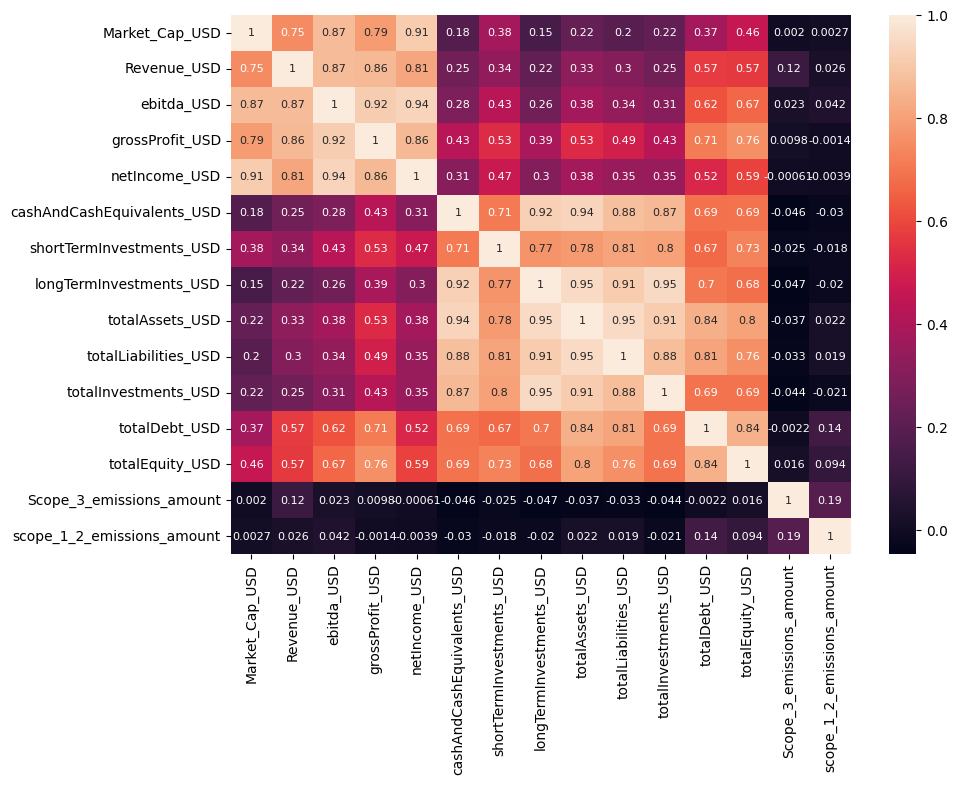

In [5]:
#plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(use_sold_products[numeric_cols].corr(), annot=True, annot_kws={"size": 8})
plt.show()

In [6]:
#correlation matrix
use_sold_products[numeric_cols].corr()

,Market_Cap_USD,Revenue_USD,ebitda_USD,grossProfit_USD,netIncome_USD,cashAndCashEquivalents_USD,shortTermInvestments_USD,longTermInvestments_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount
Market_Cap_USD,1.000000,0.747858,0.871899,0.788095,0.913663,0.179452,0.377960,0.150255,0.223439,0.196711,0.215216,0.374389,0.461069,0.001962,0.002734
Revenue_USD,0.747858,1.000000,0.872024,0.862193,0.811920,0.251639,0.336283,0.218485,0.326285,0.301511,0.252627,0.570636,0.569733,0.115166,0.025583
ebitda_USD,0.871899,0.872024,1.000000,0.918117,0.936238,0.284528,0.427771,0.259287,0.377622,0.340535,0.311181,0.619754,0.667269,0.023443,0.041658
grossProfit_USD,0.788095,0.862193,0.918117,1.000000,0.864189,0.428415,0.532245,0.389898,0.526185,0.493045,0.426556,0.711023,0.756339,0.009840,-0.001411
netIncome_USD,0.913663,0.811920,0.936238,0.864189,1.000000,0.312569,0.469532,0.304284,0.377228,0.351639,0.353817,0.517807,0.589066,-0.000610,-0.003911
cashAndCashEquivalents_USD,0.179452,0.251639,0.284528,0.428415,0.312569,1.000000,0.706656,0.923919,0.935647,0.880555,0.865012,0.688770,0.691161,-0.045694,-0.030102
shortTermInvestments_USD,0.377960,0.336283,0.427771,0.532245,0.469532,0.706656,1.000000,0.769258,0.783524,0.808552,0.801467,0.669238,0.728406,-0.024631,-0.017829
longTermInvestments_USD,0.150255,0.218485,0.259287,0.389898,0.304284,0.923919,0.769258,1.000000,0.951200,0.913722,0.950116,0.702972,0.683188,-0.046911,-0.020071
totalAssets_USD,0.223439,0.326285,0.377622,0.526185,0.377228,0.935647,0.783524,0.951200,1.000000,0.951731,0.911123,0.837308,0.803725,-0.037040,0.022160
totalLiabilities_USD,0.196711,0.301511,0.340535,0.493045,0.351639,0.880555,0.808552,0.913722,0.951731,1.000000,0.875831,0.807880,0.756770,-0.032616,0.019230


In [7]:
#drop columns due to collinearity, keeping total
use_sold_products=use_sold_products.drop(columns=['grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
    'shortTermInvestments_USD', 'longTermInvestments_USD', "account_name", "Third_party_verification", "Scope_3_emissions_type"])

In [8]:
use_sold_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  2253 non-null   int64  
 1   Year                        2253 non-null   int64  
 2   incorporated_country        2253 non-null   object 
 3   Primary activity            2253 non-null   object 
 4   Primary sector              2253 non-null   object 
 5   Market_Cap_USD              2013 non-null   float64
 6   Revenue_USD                 2008 non-null   float64
 7   ebitda_USD                  2008 non-null   float64
 8   totalAssets_USD             2008 non-null   float64
 9   totalLiabilities_USD        2008 non-null   float64
 10  totalInvestments_USD        2008 non-null   float64
 11  totalDebt_USD               2008 non-null   float64
 12  totalEquity_USD             2008 non-null   float64
 13  Scope_3_emissions_amount    2253 

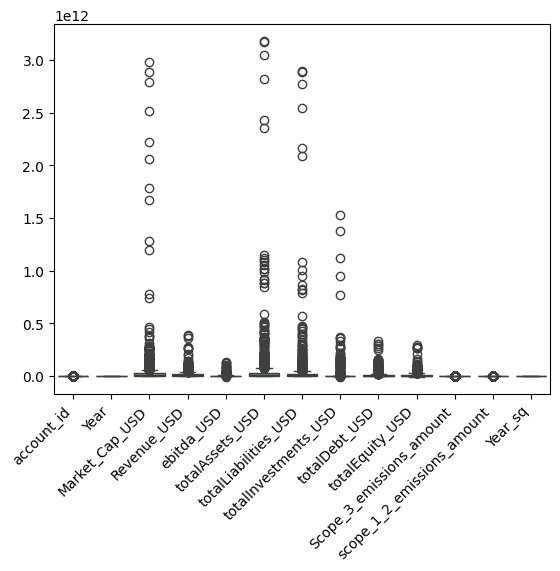

In [9]:
sns.boxplot(use_sold_products)
plt.xticks(rotation=45, ha='right')
plt.show()

In [10]:
# copy dataframe
use_sold_products_no_transform = use_sold_products.copy()
# Change 'incorporated_country' to 'Countries' in use_sold_products dataframe
use_sold_products_no_transform = use_sold_products_no_transform.rename(columns={'incorporated_country': 'Countries',
                                                       'Primary activity': 'Primary_activity',
                                                        'Primary sector': 'Primary_sector'})

print(use_sold_products_no_transform.info())
use_sold_products_no_transform.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   account_id                  2253 non-null   int64  
 1   Year                        2253 non-null   int64  
 2   Countries                   2253 non-null   object 
 3   Primary_activity            2253 non-null   object 
 4   Primary_sector              2253 non-null   object 
 5   Market_Cap_USD              2013 non-null   float64
 6   Revenue_USD                 2008 non-null   float64
 7   ebitda_USD                  2008 non-null   float64
 8   totalAssets_USD             2008 non-null   float64
 9   totalLiabilities_USD        2008 non-null   float64
 10  totalInvestments_USD        2008 non-null   float64
 11  totalDebt_USD               2008 non-null   float64
 12  totalEquity_USD             2008 non-null   float64
 13  Scope_3_emissions_amount    2253 

,account_id,Year,Countries,Primary_activity,Primary_sector,Market_Cap_USD,Revenue_USD,ebitda_USD,totalAssets_USD,totalLiabilities_USD,totalInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,scope_1_2_emissions_amount,Year_sq
0,4407,2018,United Kingdom,Electrical equipment,Electrical & electronic equipment,1.595156e+10,1.443500e+10,2.260000e+09,1.248000e+10,8.810000e+09,171000000.0,4.344000e+09,3.670000e+09,3556030.00,380471.810000,4072324
1,1104,2018,United Kingdom,Pharmaceuticals,Biotech & pharma,7.441091e+10,2.209000e+10,7.165000e+09,6.065100e+10,4.660700e+10,922000000.0,1.911300e+10,1.404400e+10,778885.00,707252.916667,4072324
2,23046,2018,United Kingdom,Residential building construction,Construction,6.017675e+09,6.049137e+09,1.152398e+09,9.353804e+09,3.170174e+09,240030000.0,1.699768e+09,6.183630e+09,4703.27,24631.930000,4072324
3,2377,2018,United Kingdom,Telecommunications services,"Media, telecommunications & data center services",2.997109e+10,2.975356e+10,9.392920e+09,5.878449e+10,4.587240e+10,128270000.0,2.143252e+10,1.291209e+10,1250000.00,457281.895000,4072324
4,2414,2018,United Kingdom,Clothing manufacture,Textiles & fabric goods,9.107209e+09,3.470656e+09,7.345680e+08,2.823210e+09,1.012952e+09,9398000.0,2.946400e+07,1.810258e+09,32700.00,68188.250000,4072324


In [11]:
use_sold_products_no_transform['Primary_sector'].value_counts()

Primary_sector
Electrical & electronic equipment                     358
Chemicals                                             195
Construction                                          176
Media, telecommunications & data center services      163
Food & beverage processing                            138
Powered machinery                                     108
Energy utility networks                                90
Discretionary retail                                   82
Medical equipment & supplies                           76
Financial services                                     69
Thermal power generation                               66
Transportation equipment                               60
Convenience retail                                     58
Biotech & pharma                                       55
Specialized professional services                      41
Trading, wholesale, distribution, rental & leasing     38
Wood & rubber products                                 31

In [12]:
use_sold_products_no_transform['Primary_activity'].value_counts().head(20)

Primary_activity
Telecommunications services              157
Electronic components                    108
Electronic equipment                      79
Other base chemicals                      73
Personal care & household products        70
Electrical equipment                      67
Communications equipment                  66
Electricity networks                      63
CCGT generation                           63
Non-residential building construction     60
Industrial machinery                      59
Supermarkets, food & drugstores           58
Pharmaceuticals                           53
Banks                                     53
Automobiles                               49
Alcoholic beverages                       49
Medical equipment                         47
Residential building construction         44
Other food processing                     43
Other professional services               41
Name: count, dtype: int64

In [13]:
# Looking at missing data
print(use_sold_products_no_transform.isnull().mean().sort_values(ascending=False).round(3) * 100)

Revenue_USD                   10.9
ebitda_USD                    10.9
totalAssets_USD               10.9
totalLiabilities_USD          10.9
totalInvestments_USD          10.9
totalDebt_USD                 10.9
totalEquity_USD               10.9
Market_Cap_USD                10.7
scope_1_2_emissions_amount     0.2
account_id                     0.0
Year                           0.0
Countries                      0.0
Primary_activity               0.0
Primary_sector                 0.0
Scope_3_emissions_amount       0.0
Year_sq                        0.0
dtype: float64


Apply signed log transformation and split data by company and year into train_df (2018-2022) and test_df (2023):

In [14]:
numeric_cols = ['Market_Cap_USD', 'Revenue_USD', 'ebitda_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_amount',
       'scope_1_2_emissions_amount'
]
required_cols = [
    'account_id', 'Year', 'Year_sq', 'Countries', 'Primary_activity', 'Primary_sector'
] + numeric_cols

# --- Prepare Data ---
df = use_sold_products_no_transform[required_cols].dropna()

# --- Signed log transform ---
def signed_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

for col in numeric_cols:
    df[f'slog_{col}'] = signed_log(df[col])

# --- Company-level split by year ---
train_df = df[df['Year'].between(2018, 2022)].copy()
test_df  = df[df['Year'] == 2023].copy()

# Keep only companies present in training
valid_companies = set(train_df['account_id'].unique())
test_df = test_df[test_df['account_id'].isin(valid_companies)].copy()

# --- Remove rare categories in Primary_activity and Countries (≤2 rows) to prevent singular matrices ---
for col in ['Primary_activity', 'Countries']:
    value_counts = train_df[col].value_counts()
    allowed = value_counts[value_counts > 2].index
    train_df = train_df[train_df[col].isin(allowed)].copy()
    test_df = test_df[test_df[col].isin(allowed)].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1568, 26)
Test shape: (336, 26)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1568 entries, 0 to 1791
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       1568 non-null   int64  
 1   Year                             1568 non-null   int64  
 2   Year_sq                          1568 non-null   int64  
 3   Countries                        1568 non-null   object 
 4   Primary_activity                 1568 non-null   object 
 5   Primary_sector                   1568 non-null   object 
 6   Market_Cap_USD                   1568 non-null   float64
 7   Revenue_USD                      1568 non-null   float64
 8   ebitda_USD                       1568 non-null   float64
 9   totalAssets_USD                  1568 non-null   float64
 10  totalLiabilities_USD             1568 non-null   float64
 11  totalInvestments_USD             1568 non-null   float64
 12  totalDebt_USD            

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 336 entries, 1792 to 2249
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       336 non-null    int64  
 1   Year                             336 non-null    int64  
 2   Year_sq                          336 non-null    int64  
 3   Countries                        336 non-null    object 
 4   Primary_activity                 336 non-null    object 
 5   Primary_sector                   336 non-null    object 
 6   Market_Cap_USD                   336 non-null    float64
 7   Revenue_USD                      336 non-null    float64
 8   ebitda_USD                       336 non-null    float64
 9   totalAssets_USD                  336 non-null    float64
 10  totalLiabilities_USD             336 non-null    float64
 11  totalInvestments_USD             336 non-null    float64
 12  totalDebt_USD          

In [17]:
# Check number of 0's in train and test df's
print((train_df == 0).sum().sum())
print((test_df == 0).sum().sum())

46
12


## Use of Sold Products Null Mixed-Effects Model

Null mixed-effects model (random intercept only) to predict log-transformed Scope 3 emissions. The model serves as a baseline, capturing only the average emission level for each company, without incorporating any explanatory variables, and quantifies the improvement gained by including additional features and structure. The model is trained on 2018–2022 data and evaluated on a test set from 2023.

Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies
- Fixed Effects:
    - Intercept only (no predictors)

                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 1568    Method:             REML                        
No. Groups:       392     Scale:              0.5343                      
Min. group size:  1       Log-Likelihood:     -2539.4157                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  4.0                                                     
------------------------------------------------------------------------------
                Coef.      Std.Err.       z        P>|z|     [0.025     0.975]
------------------------------------------------------------------------------
Intercept       13.203        0.152     86.929     0.000     12.905     13.501
Group Var        8.868        1.022                                           

R²(log):    -2.23%
R²(orig):   -31.47%
MAPE:       34938.37%
MAPE(log):  20.63%
MAE(log):   2.29
R

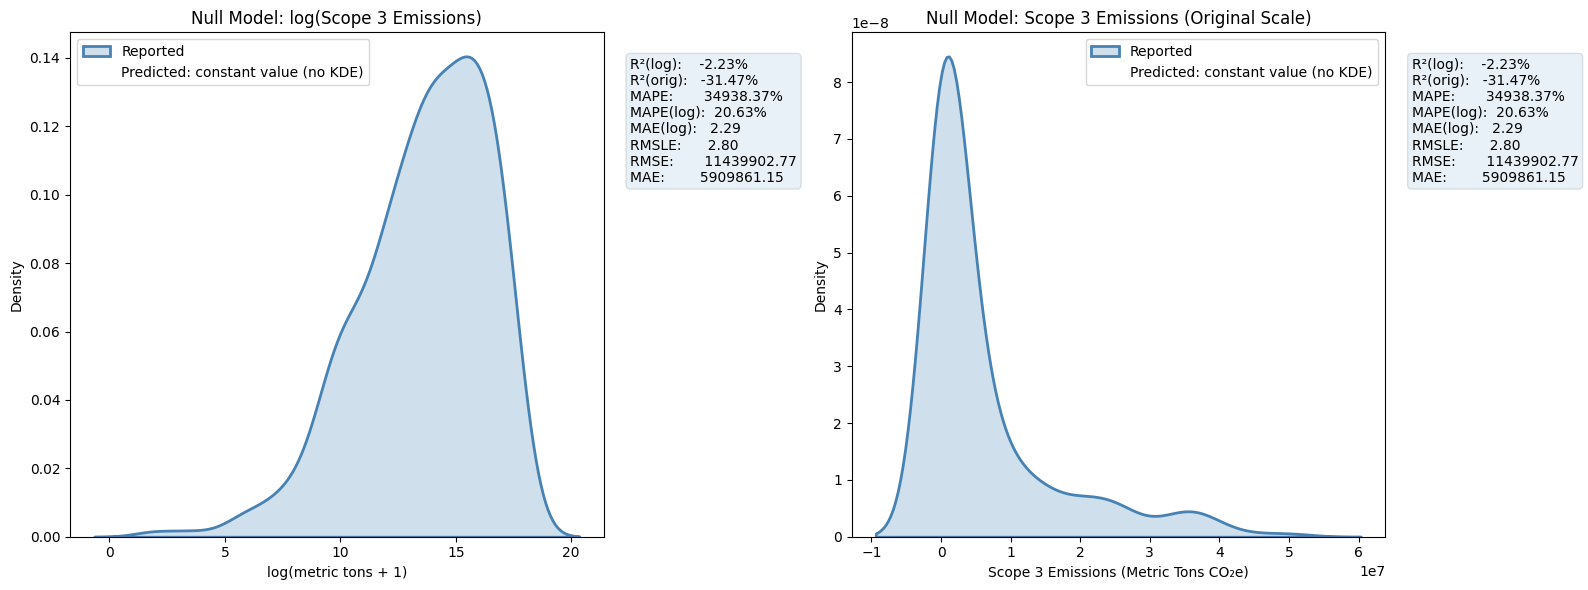

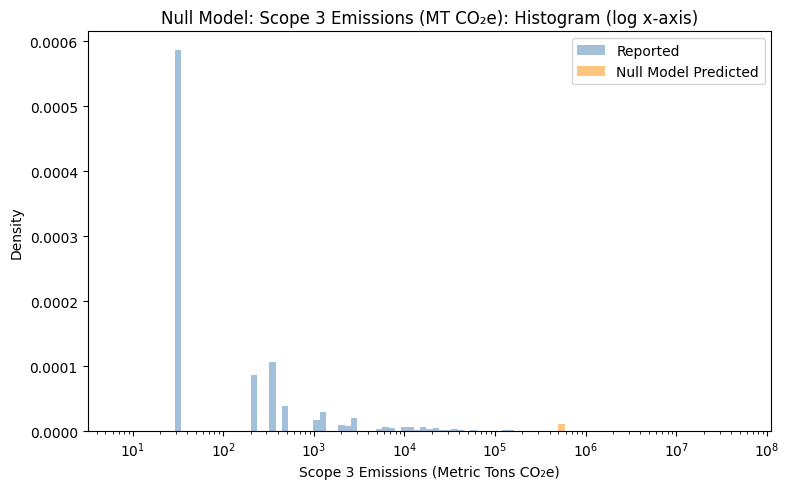

In [18]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE NULL MODEL (random intercept only) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    null_model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ 1",
        train_df,
        groups=train_df["account_id"]
    )
    null_result = null_model.fit(method="lbfgs")

if not null_result.converged:
    print("WARNING: Null model did not fully converge.")

print(null_result.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_null'] = null_result.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_null']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_null'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics text
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[0], color='gray')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Null Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Null Model Predicted', linewidth=2, fill=True, ax=axes[1], color='gray')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Null Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Null Model Predicted")
plt.xscale("log")
plt.title("Null Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
null_model_metrics = {
    "Model": "Null (RI)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "Random intercept only"
}

## Use of Sold Products Two-Level Mixed-Effects Model

Two-level hierarchical linear mixed-effects model to predict log-transformed Scope 3 emissions at the company level. The model is fit to training data (from 2018–2022), and predictions are evaluated on a test set (from 2023).  This model provides a baseline for including time trends and company-level variability.
 
Model Structure:
- Random Effects:
    - Random intercept for each company ('account_id'), capturing baseline differences between companies.<br>
- Fixed Effects:
    - Year (numeric)
    - Year squared ('Year_sq', quadratic time trend)

Two-Level Model: Company/year group size summary:
count    392.000000
mean       4.000000
std        1.425023
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
dtype: float64
                  Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_Scope_3_emissions_amount
No. Observations: 1568    Method:             REML                        
No. Groups:       392     Scale:              0.5350                      
Min. group size:  1       Log-Likelihood:     -2545.9801                  
Max. group size:  5       Converged:          Yes                         
Mean group size:  4.0                                                     
----------------------------------------------------------------------------
               Coef.      Std.Err.     z      P>|z|     [0.025       0.975] 
----------------------------------------------------------------------------
Intercept     5895.964   46625.709    

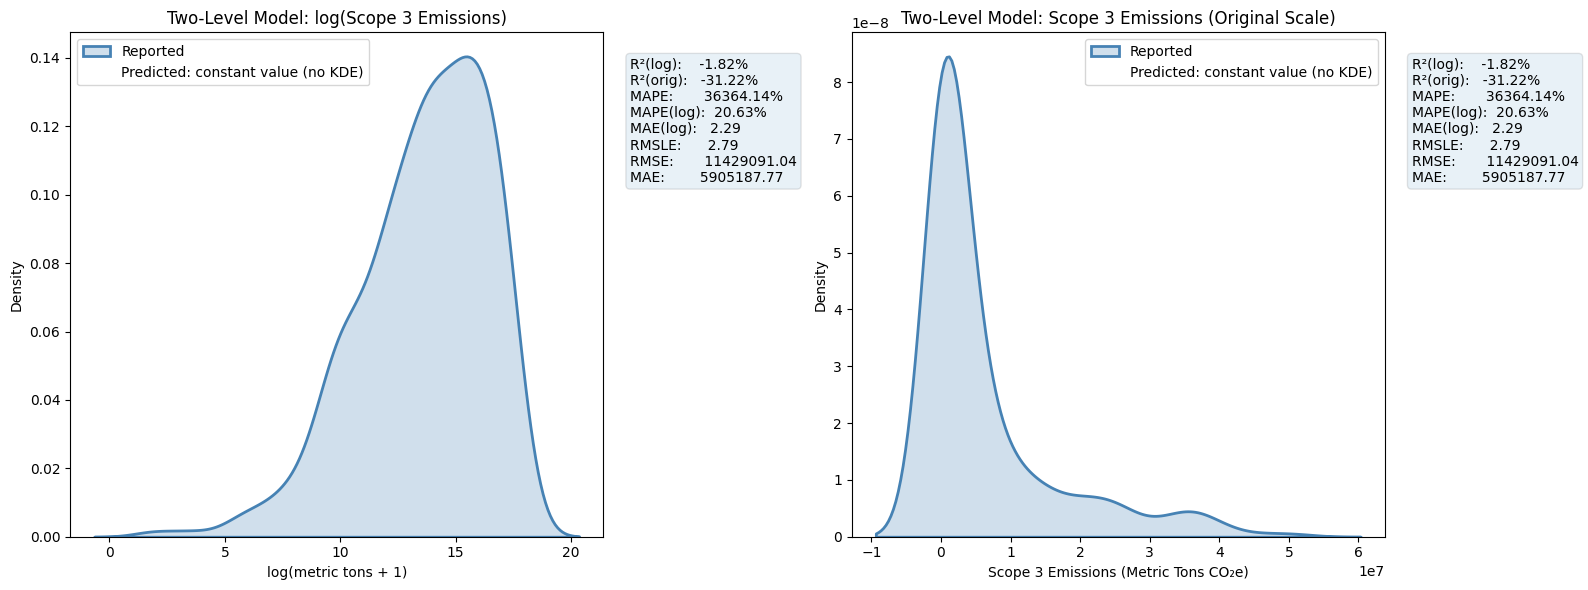

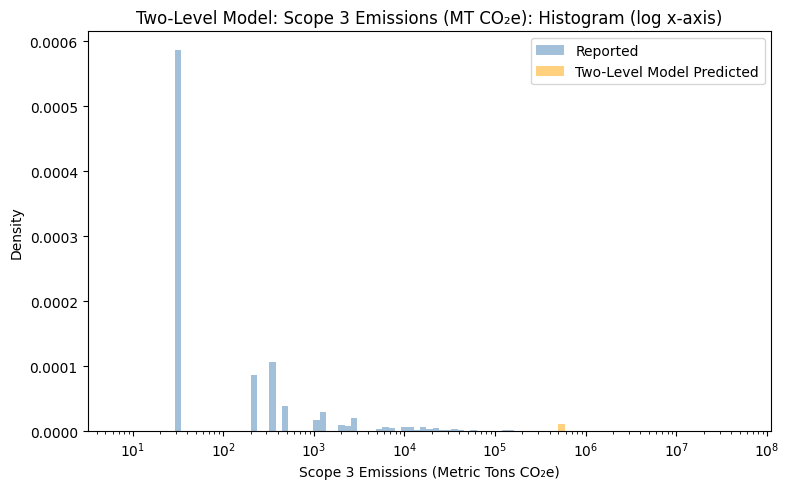

In [19]:
# --- Ensure log_Scope_3_emissions_amount exists (if not, create it) ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- Check group sizes ---
group_sizes = train_df.groupby('account_id').size()
print("Two-Level Model: Company/year group size summary:")
print(group_sizes.describe())

# --- FIT THE TWO-LEVEL MODEL (random intercept, +Year, +Year_sq) ---
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model = smf.mixedlm(
        "log_Scope_3_emissions_amount ~ Year + Year_sq",
        train_df,
        groups=train_df["account_id"],
        re_formula="1"
    )
    result_twolevel = model.fit(method="lbfgs")

if not result_twolevel.converged:
    print("WARNING: Two-level mixed model did not fully converge.")

print(result_twolevel.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_twolevel.predict(test_df)

# --- METRICS ---
y_true_log = test_df['log_Scope_3_emissions_amount']
y_pred_log = test_df['predicted_mixed']

# Remove inf/nan for robust metrics
mask = np.isfinite(y_true_log) & np.isfinite(y_pred_log)
y_true_log = y_true_log[mask]
y_pred_log = y_pred_log[mask]
test_df = test_df.loc[mask].copy()

# Log-scale MAPE
mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100

# Back-transform for original scale metrics
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])
y_true = test_df['Reported_Scope_3']
y_pred = test_df['Predicted_Scope_3']

# Remove inf/nan for robust metrics
mask2 = np.isfinite(y_true) & np.isfinite(y_pred)
y_true = y_true[mask2]
y_pred = y_pred[mask2]

# Metrics calculations
r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_orig_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)
mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

# Print metrics
metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_orig_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Density plot on log scale
if y_pred_log.nunique() > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='orange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Two-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()

axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

# 2. Density plot on original scale
if y_pred.nunique() > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Two-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='orange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Two-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()

axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Histogram on original scale with log x-axis
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

plt.figure(figsize=(8, 5))
sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
sns.histplot(y_pred, bins=log_bins, stat="density", color="orange", alpha=0.5, label="Two-Level Model Predicted")
plt.xscale("log")
plt.title("Two-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# --- RETURN METRICS FOR SUMMARY TABLE ---
two_level_model_metrics = {
    "Model": "2-level (RI+S)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_orig_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,  # <--- include MAE for log-transformed emissions
    "Notes": "+Year, Year_sq"
}

## Use of Sold Products Three-Level Mixed-Effects Model

A three-level hierarchical linear mixed-effects model is used to predict log-transformed Scope 3 emissions. It takes into account differences between primary activity, differences between companies, and changes over time. The model is trained using data from 2018 to 2022, and then tested on new data from 2023. This model provides insight on how emissions are influenced by primary activity, by individual companies, by financial and emissions factors, and by trends over time.

Model Structure:

- Level 3 (Primary Activity):<br>
    - Random intercept and random slope for Year for each primary activity ('Primary_activity'), capturing baseline primary activity and primary activity-specific time trends.<br>
- Level 2 (Account/Company):
    - Random intercept for each company ('account_id'), capturing company-level deviations within each primary activity.
- Level 1 (Yearly Observations):
    - Repeated annual observations within each company.

- Fixed Effects:
    - Signed log-transformed market cap ('slog_Market_Cap_USD')
    - Signed log-transformed revenue ('slog_Revenue_USD')
    - Signed log-transformed EBITDA ('slog_ebitda_USD')
    - Signed log-transformed Scope 1 & 2 emissions ('slog_scope_1_2_emissions_amount')

                     Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  log_Scope_3_emissions_amount
No. Observations:    1568     Method:              REML                        
No. Groups:          85       Scale:               0.5195                      
Min. group size:     3        Log-Likelihood:      -2478.1232                  
Max. group size:     109      Converged:           Yes                         
Mean group size:     18.4                                                      
-------------------------------------------------------------------------------
                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                             6.298    1.319  4.775 0.000  3.713  8.883
slog_Market_Cap_USD                   0.137    0.053  2.597 0.009  0.034  0.241
slog_Revenue_USD                      0.049    0.024  2.069 0

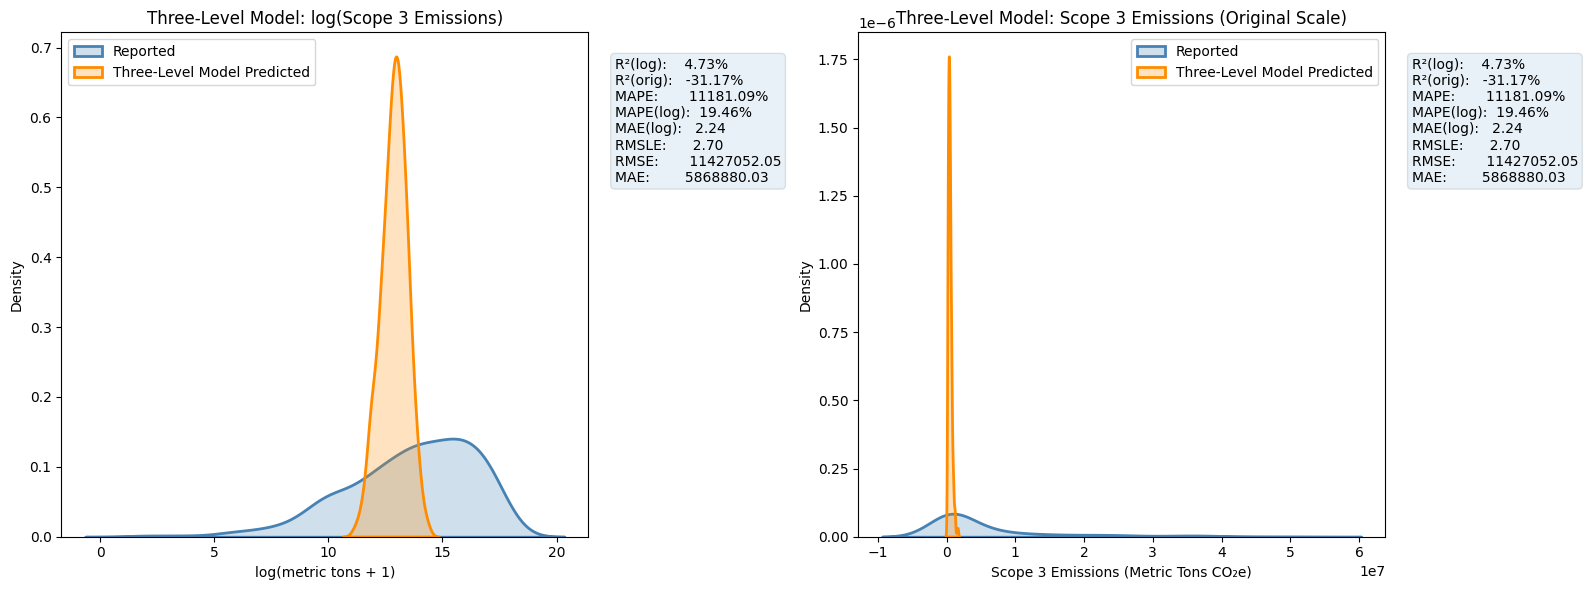

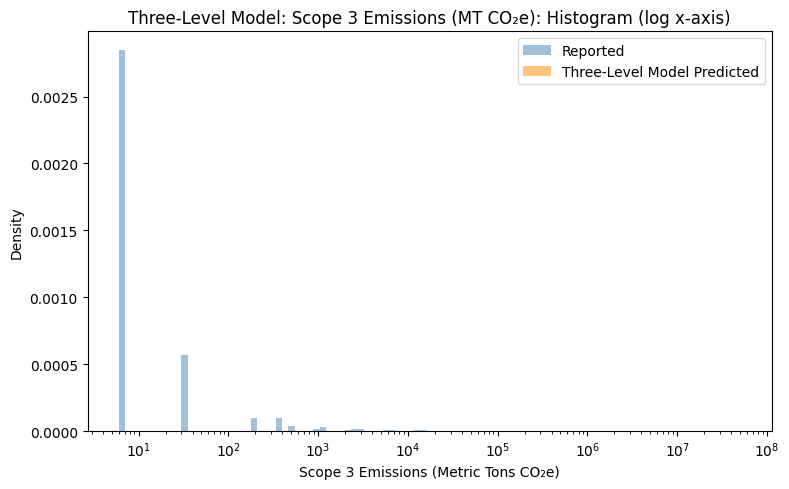

In [20]:
# --- Ensure grouping/categorical variables are string ---
for col in ['Countries', 'account_id', 'Primary_activity', 'Primary_sector']:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# --- Center the Year variable ---
year_mean = train_df['Year'].mean()
train_df['Year_centered'] = train_df['Year'] - year_mean
test_df['Year_centered'] = test_df['Year'] - year_mean

# --- Ensure log-transformed target exists ---
if 'log_Scope_3_emissions_amount' not in train_df.columns:
    train_df['log_Scope_3_emissions_amount'] = np.log1p(train_df['Scope_3_emissions_amount'])
if 'log_Scope_3_emissions_amount' not in test_df.columns:
    test_df['log_Scope_3_emissions_amount'] = np.log1p(test_df['Scope_3_emissions_amount'])

# --- FIT THE 3-LEVEL MIXED MODEL with Primary_activity as Level 3 group ---
vc = {'account_id': '0 + C(account_id)'}  # Level 2: account_id random intercept

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    model_3level = MixedLM.from_formula(
        'log_Scope_3_emissions_amount ~ slog_Market_Cap_USD + slog_Revenue_USD + slog_ebitda_USD + slog_scope_1_2_emissions_amount',
        groups='Primary_activity',
        re_formula='~Year_centered',
        vc_formula=vc,
        data=train_df
    )
    result_3level = model_3level.fit(method="lbfgs", maxiter=1000)

if not result_3level.converged:
    print("WARNING: Three-level mixed model did not fully converge.")

print(result_3level.summary())

# --- PREDICT ON TEST SET ---
test_df = test_df.copy()
test_df['predicted_mixed'] = result_3level.predict(test_df)

# --- Compute back-transformed values ---
test_df['Reported_Scope_3'] = np.expm1(test_df['log_Scope_3_emissions_amount'])
test_df['Predicted_Scope_3'] = np.expm1(test_df['predicted_mixed'])

# --- Robust Mask for finite values everywhere ---
mask = (
    np.isfinite(test_df['log_Scope_3_emissions_amount']) &
    np.isfinite(test_df['predicted_mixed']) &
    np.isfinite(test_df['Reported_Scope_3']) &
    np.isfinite(test_df['Predicted_Scope_3'])
)
test_df = test_df.loc[mask].copy()

y_true_log = test_df['log_Scope_3_emissions_amount'].values
y_pred_log = test_df['predicted_mixed'].values
y_true = test_df['Reported_Scope_3'].values
y_pred = test_df['Predicted_Scope_3'].values

# Final defensive check and diagnostics
arrays = {
    "y_true_log": y_true_log,
    "y_pred_log": y_pred_log,
    "y_true": y_true,
    "y_pred": y_pred,
}
for arr_name, arr in arrays.items():
    if not np.all(np.isfinite(arr)):
        print(f"ERROR: {arr_name} contains non-finite values!")
        print(f"Non-finite indices: {np.where(~np.isfinite(arr))[0]}")
        print(f"Values: {arr[~np.isfinite(arr)]}")
        raise ValueError(f"{arr_name} contains infs or NaNs after masking!")

# --- METRICS ---
mae_log = mean_absolute_error(y_true_log, y_pred_log)
nonzero_mask = y_true_log != 0
if np.any(nonzero_mask):
    mape_log = np.mean(np.abs((y_true_log[nonzero_mask] - y_pred_log[nonzero_mask]) / y_true_log[nonzero_mask])) * 100
else:
    mape_log = np.nan

r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
r2_pct = r2_score(y_true, y_pred) * 100
mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
mae_orig = mean_absolute_error(y_true, y_pred)

metrics_text = (
    f"R²(log):    {r2_log_pct:.2f}%\n"
    f"R²(orig):   {r2_pct:.2f}%\n"
    f"MAPE:       {mape_orig:.2f}%\n"
    f"MAPE(log):  {mape_log:.2f}%\n"
    f"MAE(log):   {mae_log:.2f}\n"
    f"RMSLE:      {rmsle:.2f}\n"
    f"RMSE:       {rmse_orig:.2f}\n"
    f"MAE:        {mae_orig:.2f}"
)
print(metrics_text)

# --- VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
if len(np.unique(y_pred_log)) > 1:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    sns.kdeplot(y_pred_log, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
    axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[0].set_title("Three-Level Model: log(Scope 3 Emissions)")
axes[0].set_xlabel("log(metric tons + 1)")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

if len(np.unique(y_pred)) > 1:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    sns.kdeplot(y_pred, label='Three-Level Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
else:
    sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
    axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
axes[1].set_title("Three-Level Model: Scope 3 Emissions (Original Scale)")
axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
             verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.show()

# Filter strictly positive values for histogram (log x-axis requires >0)
y_true_pos = y_true[y_true > 0]
y_pred_pos = y_pred[y_pred > 0]

if y_true_pos.size > 0 and y_pred_pos.size > 0:
    min_val = min(y_true_pos.min(), y_pred_pos.min())
    max_val = max(y_true_pos.max(), y_pred_pos.max())
    if min_val == max_val:
        print("Skipping histogram: Only one unique positive value present.")
    else:
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 100)

        plt.figure(figsize=(8, 5))
        sns.histplot(y_true_pos, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
        sns.histplot(y_pred_pos, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Three-Level Model Predicted")
        plt.xscale("log")
        plt.title("Three-Level Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
        plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("Skipping histogram: Not enough positive values in y_true or y_pred for log-scale histogram.")

# --- RETURN METRICS FOR SUMMARY TABLE ---
three_level_model_metrics = {
    "Model": "3-level (Primary Activity/Account/Year)",
    "R2_log": r2_log_pct / 100,
    "R2_orig": r2_pct / 100,
    "RMSE": rmse_orig,
    "MAE": mae_orig,
    "RMSLE": rmsle,
    "MAPE": mape_orig,
    "MAE_log": mae_log,
    "MAPE(log)": mape_log,
}

## Use of Sold Products Full Mixed-Effects Model

A full mixed-effects model is used to predict company Scope 3 emissions, using financial and emissions data, along with information about country, industry, and year. The model is trained on data from 2018 to 2022, and tested on data from 2023. This full model helps provides insights into how a company’s finances, emissions, primary activity, country and the year influence emissions.<br>

Model Structure:<br>

- Random Effects:<br>
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:<br>
    - Signed log-transformed financial and emissions features:<br>
        - Market Cap ('slog_Market_Cap_USD')<br>
        - Revenue ('slog_Revenue_USD')<br>
        - EBITDA ('slog_ebitda_USD')<br>
        - Total Investments ('slog_totalInvestments_USD')<br>
        - Total Debt ('slog_totalDebt_USD')<br>
        - Total Assets ('slog_totalAssets_USD')<br>
        - Total Liabilities ('slog_totalLiabilities_USD')<br>
        - Total Equity ('slog_totalEquity_USD')<br>
        - Scope 1&2 Emissions ('slog_scope_1_2_emissions_amount')<br>
    - Country ('Countries', as a categorical variable)<br>
    - Primary Activity ('Primary_activity', as a categorical variable)<br>
    - Year (numeric)<br>

                                         Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                 1568                  Method:                           ML                           
No. Groups:                       392                   Scale:                            0.5421                       
Min. group size:                  1                     Log-Likelihood:                   -2304.0212                   
Max. group size:                  5                     Converged:                        Yes                          
Mean group size:                  4.0                                                                                  
-----------------------------------------------------------------------------------------------------------------------
                                                                           Coef. 

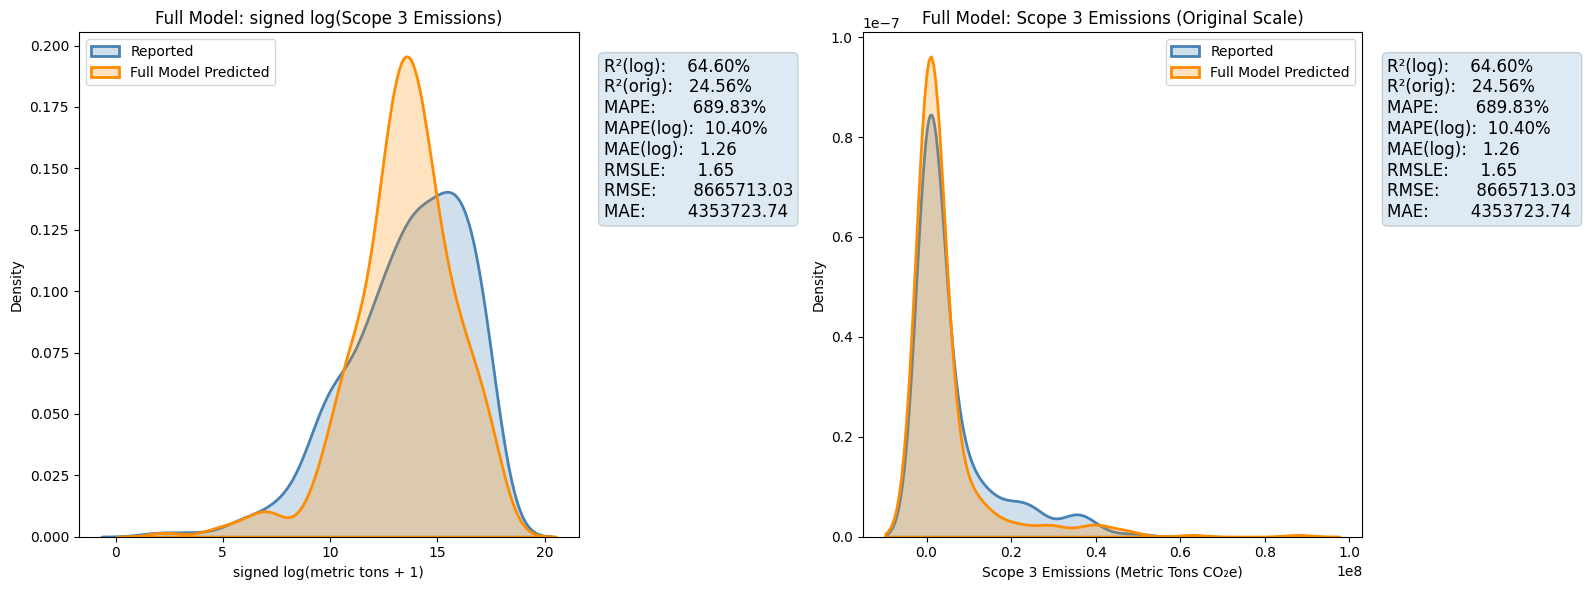

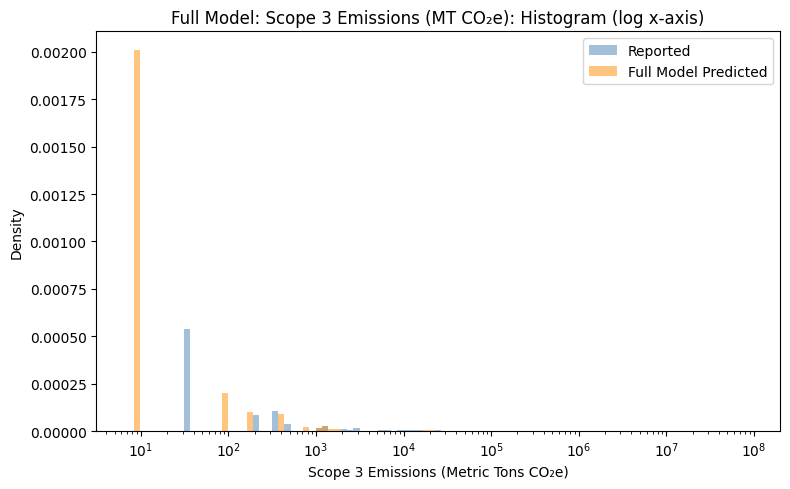

In [21]:
# --- Feature and target columns ---
numeric_cols = ['Market_Cap_USD',
 'Revenue_USD',
 'ebitda_USD',
 'totalAssets_USD',
 'totalLiabilities_USD',
 'totalInvestments_USD',
 'totalDebt_USD',
 'totalEquity_USD',
 'Scope_3_emissions_amount',
 'scope_1_2_emissions_amount'
]
feature_cols_slog = [f'slog_{col}' for col in numeric_cols if col != 'Scope_3_emissions_amount']
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
required_cols = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_full = train_df.dropna(subset=required_cols).copy()
test_df_full = test_df.dropna(subset=required_cols).copy()

if test_df_full.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity) + Year'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the full mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_full, groups=train_df_full['account_id'])
        mdf = md.fit(reml=False)
    print(mdf.summary())

    # --- Predict on test set ---
    test_df_full['predicted_log'] = mdf.predict(test_df_full)
    test_df_full['predicted'] = np.sign(test_df_full['predicted_log']) * (np.expm1(np.abs(test_df_full['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_full[target_col_slog]
    y_pred_log = test_df_full['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_full['predicted']

    # Mask for finite values
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <--- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nFull Mixed-Effects Model (Full Model) Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf.params,
        'pvalue': mdf.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Full Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Full Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Full Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Full Model Predicted")
    plt.xscale("log")
    plt.title("Full Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    full_model_metrics = {
        "Model": "Full Model",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

## Use of Sold Products Optimized Mixed-Effects Model

An optimized mixed-effects model is used to predict company Scope 3 emissions. The model provides accurate prediction using only the most significant predictive features, while still accounting for primary activity, country and company level effects. The model is trained on data from 2018–2022 and evaluated on test data from 2023.

Model Structure:

- Random Effects:
    - Random intercept for each company ('account_id'), capturing company-level baseline differences
- Fixed Effects:
    - Signed log-transformed features:
        - Revenue ('slog_Revenue_USD')
        - Total Assets ('slog_totalAssets_USD')
        - Total Liabilities ('slog_totalLiabilities_USD')
        - Scope 1 & 2 Emissions ('slog_scope_1_2_emissions_amount')
    - Country ('Countries', as a categorical variable)
    - Primary Activity ('Primary_activity', as a categorical variable)

                                        Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               slog_Scope_3_emissions_amount
No. Observations:                1568                  Method:                           ML                           
No. Groups:                      392                   Scale:                            0.5437                       
Min. group size:                 1                     Log-Likelihood:                   -2307.9434                   
Max. group size:                 5                     Converged:                        Yes                          
Mean group size:                 4.0                                                                                  
----------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err

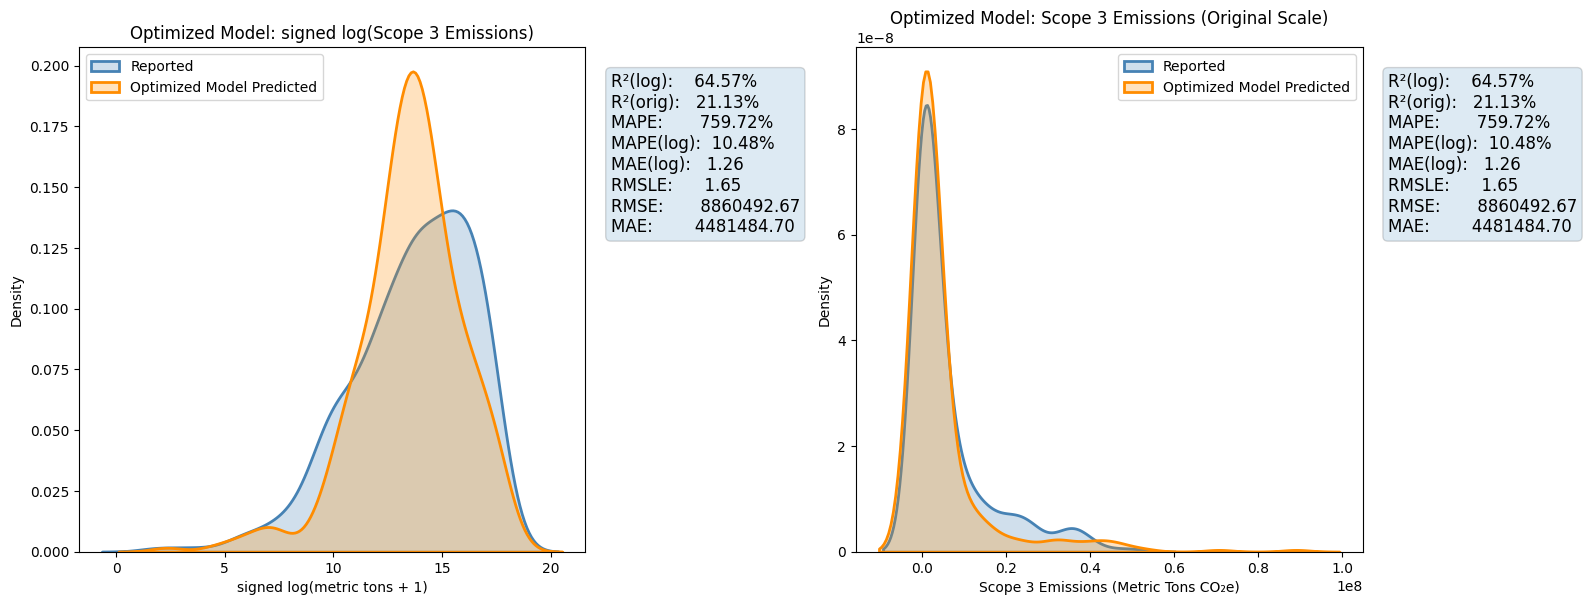

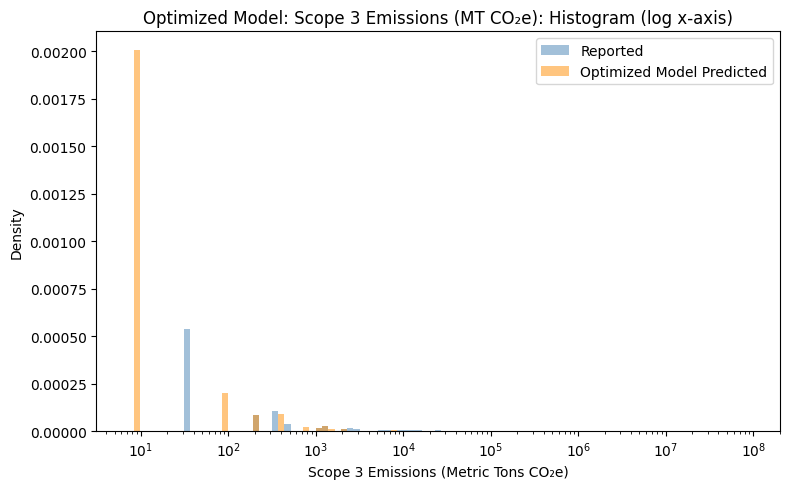

In [22]:
feature_cols_slog = [
    'slog_Revenue_USD',
    'slog_totalAssets_USD',
    'slog_totalLiabilities_USD',
    'slog_scope_1_2_emissions_amount'
]
target_col_slog = 'slog_Scope_3_emissions_amount'

# --- Filter for required columns only ---
all_model_vars = feature_cols_slog + [target_col_slog, 'Countries', 'Year', 'account_id', 'Primary_activity']
train_df_opt = train_df.dropna(subset=all_model_vars).copy()
test_df_opt = test_df.dropna(subset=all_model_vars).copy()

if test_df_opt.empty:
    print("WARNING: The filtered test set is empty. No predictions or metrics can be computed.")
else:
    # --- Model formula ---
    fixed_effects = (
        ' + '.join(feature_cols_slog) +
        ' + C(Countries) + C(Primary_activity)'
    )
    formula = f'{target_col_slog} ~ {fixed_effects}'

    # --- Fit the optimized mixed-effects model ---
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        md = smf.mixedlm(formula, data=train_df_opt, groups=train_df_opt['account_id'])
        mdf_optimized = md.fit(reml=False)
    print(mdf_optimized.summary())

    # --- Predict on test set ---
    test_df_opt['predicted_log'] = mdf_optimized.predict(test_df_opt)
    test_df_opt['predicted'] = np.sign(test_df_opt['predicted_log']) * (np.expm1(np.abs(test_df_opt['predicted_log'])))

    # --- Metrics ---
    y_true_log = test_df_opt[target_col_slog]
    y_pred_log = test_df_opt['predicted_log']
    y_true = np.sign(y_true_log) * (np.expm1(np.abs(y_true_log)))
    y_pred = test_df_opt['predicted']

    # Mask for valid/finites
    mask = (
        np.isfinite(y_true_log) & np.isfinite(y_pred_log) &
        np.isfinite(y_true) & np.isfinite(y_pred)
    )
    y_true_log = y_true_log[mask]
    y_pred_log = y_pred_log[mask]
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Metrics calculations
    r2_log_pct = r2_score(y_true_log, y_pred_log) * 100
    r2_pct = r2_score(y_true, y_pred) * 100
    mape_log = np.mean(np.abs((y_true_log - y_pred_log) / np.clip(y_true_log, 1e-8, None))) * 100
    mape_orig = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    rmsle = np.sqrt(mean_squared_log_error(np.abs(y_true) + 1, np.abs(y_pred) + 1))
    rmse_orig = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_orig = mean_absolute_error(y_true, y_pred)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)  # <-- MAE for log-transformed emissions

    metrics_text = (
        f"R²(log):    {r2_log_pct:.2f}%\n"
        f"R²(orig):   {r2_pct:.2f}%\n"
        f"MAPE:       {mape_orig:.2f}%\n"
        f"MAPE(log):  {mape_log:.2f}%\n"
        f"MAE(log):   {mae_log:.2f}\n"
        f"RMSLE:      {rmsle:.2f}\n"
        f"RMSE:       {rmse_orig:.2f}\n"
        f"MAE:        {mae_orig:.2f}"
    )

    print("\nOptimized Mixed-Effects Model: Test Set Performance Metrics:")
    print(metrics_text)

    # --- Feature coefficients ---
    coef_df = pd.DataFrame({
        'coef': mdf_optimized.params,
        'pvalue': mdf_optimized.pvalues
    }).drop(index="Intercept", errors='ignore').sort_values(by="pvalue")
    print("\nTop Influential Features (by p-value):")
    print(coef_df.head(10))

    print("\nAll feature coefficients sorted by absolute value:")
    print(coef_df.reindex(coef_df['coef'].abs().sort_values(ascending=False).index))

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Density plot on log scale
    if y_pred_log.nunique() > 1:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[0], color='darkorange')
    else:
        sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=axes[0], color='steelblue')
        axes[0].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[0].set_title("Optimized Model: signed log(Scope 3 Emissions)")
    axes[0].set_xlabel("signed log(metric tons + 1)")
    axes[0].set_ylabel("Density")
    axes[0].legend()

    axes[0].text(1.05, 0.95, metrics_text, transform=axes[0].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    # 2. Density plot on original scale
    if y_pred.nunique() > 1:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        sns.kdeplot(y_pred, label='Optimized Model Predicted', linewidth=2, fill=True, ax=axes[1], color='darkorange')
    else:
        sns.kdeplot(y_true, label='Reported', linewidth=2, fill=True, ax=axes[1], color='steelblue')
        axes[1].plot([], [], ' ', label="Predicted: constant value (no KDE)")
    axes[1].set_title("Optimized Model: Scope 3 Emissions (Original Scale)")
    axes[1].set_xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    axes[1].set_ylabel("Density")
    axes[1].legend()

    axes[1].text(1.05, 0.95, metrics_text, transform=axes[1].transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', alpha=0.15))

    plt.tight_layout()
    plt.show()

    # Histogram on original scale with log x-axis
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    log_bins = np.logspace(np.log10(min_val + 1), np.log10(max_val + 1), 100)

    plt.figure(figsize=(8, 5))
    sns.histplot(y_true, bins=log_bins, stat="density", color="steelblue", alpha=0.5, label="Reported")
    sns.histplot(y_pred, bins=log_bins, stat="density", color="darkorange", alpha=0.5, label="Optimized Model Predicted")
    plt.xscale("log")
    plt.title("Optimized Model: Scope 3 Emissions (MT CO₂e): Histogram (log x-axis)")
    plt.xlabel("Scope 3 Emissions (Metric Tons CO₂e)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- RETURN METRICS FOR SUMMARY TABLE ---
    optimized_model_metrics = {
        "Model": "Optimized",
        "R2_log": r2_log_pct / 100,
        "R2_orig": r2_pct / 100,
        "RMSE": rmse_orig,
        "MAE": mae_orig,
        "RMSLE": rmsle,
        "MAPE": mape_orig,
        "MAE_log": mae_log
    }

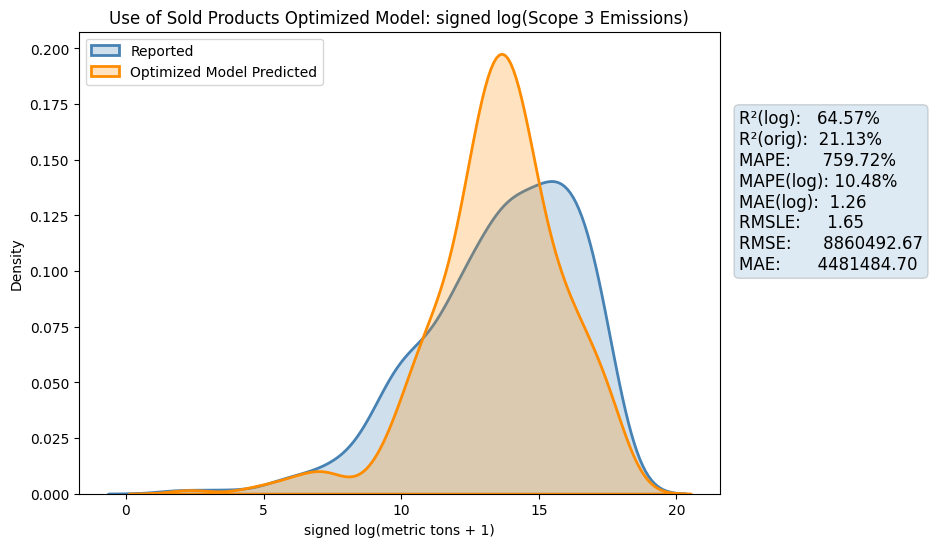

In [23]:
metrics_text_log = (
    f"R²(log):   {r2_log_pct:.2f}%\n"
    f"R²(orig):  {r2_pct:.2f}%\n"
    f"MAPE:      {mape_orig:.2f}%\n"
    f"MAPE(log): {mape_log:.2f}%\n"
    f"MAE(log):  {mae_log:.2f}\n"
    f"RMSLE:     {rmsle:.2f}\n"
    f"RMSE:      {rmse_orig:.2f}\n"
    f"MAE:       {mae_orig:.2f}"
)

fig, ax = plt.subplots(figsize=(9.5, 6))  # Wider to make room for the box

if hasattr(y_pred_log, "nunique"):
    multiple_vals = y_pred_log.nunique() > 1
else:
    multiple_vals = len(set(y_pred_log)) > 1

if multiple_vals:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    sns.kdeplot(y_pred_log, label='Optimized Model Predicted', linewidth=2, fill=True, ax=ax, color='darkorange')
else:
    sns.kdeplot(y_true_log, label='Reported', linewidth=2, fill=True, ax=ax, color='steelblue')
    ax.plot([], [], ' ', label="Predicted: constant value (no KDE)")

ax.set_title("Use of Sold Products Optimized Model: signed log(Scope 3 Emissions)")
ax.set_xlabel("signed log(metric tons + 1)")
ax.set_ylabel("Density")
ax.legend()

# Place metrics box outside plot to the right
fig.text(
    0.82, 0.75, metrics_text_log,
    va='top', ha='left',
    fontsize=12, bbox=dict(boxstyle='round', alpha=0.15)
)

plt.subplots_adjust(right=0.8)  # Make sure there's room for the box
fig.savefig("use_of_sold_products_scope3_log_density.png", dpi=300, bbox_inches='tight')
plt.show()

# Metrics Table for Use of Sold Products

In [24]:
metrics_dicts = [
    null_model_metrics,
    two_level_model_metrics,
    three_level_model_metrics,
    full_model_metrics,
    optimized_model_metrics
]

for metrics, train, test in zip(
        metrics_dicts,
        [train_df, train_df, train_df, train_df, train_df],
        [test_df, test_df, test_df, test_df, test_df]):
    
    metrics["# Obs (train)"] = len(train)
    metrics["# Obs (test)"] = len(test)
    metrics["# Obs (train/test)"] = f"{len(train)}/{len(test)}"

metrics_df = pd.DataFrame(metrics_dicts)

# Ensure all relevant columns are ordered and present
desired_order = [
    "Model", "R2_log", "R2_orig", "RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "# Obs (train/test)"
]


# Ensure MAE_log is present, fill with NaN if missing
if "MAE_log" not in metrics_df.columns:
    metrics_df["MAE_log"] = np.nan

metrics_df = metrics_df[[col for col in desired_order if col in metrics_df.columns]]

metrics_df_display = metrics_df.copy()
if "R2_log" in metrics_df_display.columns:
    metrics_df_display["R2_log"] = (metrics_df_display["R2_log"] * 100).map("{:.2f}%".format)
if "R2_orig" in metrics_df_display.columns:
    metrics_df_display["R2_orig"] = (metrics_df_display["R2_orig"] * 100).map("{:.2f}%".format)
for col in ["RMSE", "MAE", "MAE_log", "RMSLE", "MAPE", "MAPE(log)"]:
    if col in metrics_df_display.columns:
        metrics_df_display[col] = metrics_df_display[col].map("{:.2f}".format)

from IPython.display import display
display(metrics_df_display)

,Model,R2_log,R2_orig,RMSE,MAE,MAE_log,RMSLE,MAPE,# Obs (train/test)
0,Null (RI),-2.23%,-31.47%,11439902.77,5909861.15,2.29,2.80,34938.37,1568/336
1,2-level (RI+S),-1.82%,-31.22%,11429091.04,5905187.77,2.29,2.79,36364.14,1568/336
2,3-level (Primary Activity/Account/Year),4.73%,-31.17%,11427052.05,5868880.03,2.24,2.70,11181.09,1568/336
3,Full Model,64.60%,24.56%,8665713.03,4353723.74,1.26,1.65,689.83,1568/336
4,Optimized,64.57%,21.13%,8860492.67,4481484.70,1.26,1.65,759.72,1568/336
